# SBANN
## ~~Standard boring ass neural network~~
## Size and Batch Adaptable Neural Network

Import necessary packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Data

Define core features of the dataset

In [2]:
dim = 2
numpart = 24
latent_dim = 100

Import and reshape data

In [3]:
fname="mc-sampling/good-runs/nonpolimero_x.txt"
with open(fname) as f:
    data = [
        [float(i.strip()) for i in s.split(" ") if i != ""]
        for s in f.read().split("\n")
        if s != ""]

In [4]:
print(data[1])

[0.434266, 5.15381, 3.0801, 2.485895, 7.595433, 2.530519, 5.536051, 6.890176, 6.794987, 5.597419, 3.654383, 3.309541, 1.611617, 0.149436, 5.163913, 4.719471, 0.874511, 7.721607, 5.560267, 0.349174, 3.644267, 1.596404, 6.395426, 4.590671, 1.056682, 6.700136, 6.339667, 3.218312, 4.992017, 3.45622, 2.586908, 1.270555, 7.758214, 4.767549, 1.329824, 1.4559, 2.368081, 7.578163, 6.697496, 6.866885, 4.003242, 4.295706, 7.787586, 6.300647, 2.383461, 6.276167, 4.604075, 2.506748]


In [5]:
vcs = np.array(data).reshape((-1,numpart,dim))
#vcs = np.array(data)
print(vcs.shape,vcs[1])

(10000, 24, 2) [[0.434266 5.15381 ]
 [3.0801   2.485895]
 [7.595433 2.530519]
 [5.536051 6.890176]
 [6.794987 5.597419]
 [3.654383 3.309541]
 [1.611617 0.149436]
 [5.163913 4.719471]
 [0.874511 7.721607]
 [5.560267 0.349174]
 [3.644267 1.596404]
 [6.395426 4.590671]
 [1.056682 6.700136]
 [6.339667 3.218312]
 [4.992017 3.45622 ]
 [2.586908 1.270555]
 [7.758214 4.767549]
 [1.329824 1.4559  ]
 [2.368081 7.578163]
 [6.697496 6.866885]
 [4.003242 4.295706]
 [7.787586 6.300647]
 [2.383461 6.276167]
 [4.604075 2.506748]]


## Sorting data


In [6]:
sortmode = 0

### Option 1 - x sorted cartesian coords

In [7]:
if sortmode == 1 :
    idx = np.lexsort((vcs[:,:,1], vcs[:,:,0]))
    
    # Use the indices to sort each step while maintaining the rows intact
    sorted_vcs = np.empty_like(vcs)
    for i in range(len(vcs)):
        sorted_vcs[i] = vcs[i][idx[i]]
            
    print(sorted_vcs.shape,"\n",sorted_vcs[1])

### Option 2 - distance from center sorted cartesian coords

In [8]:
if sortmode == 2 :
    def sort_by_distance_from_center(points):
        #center = np.mean(points, axis=0)
        distances = np.linalg.norm(points, axis=1)
        sorted_indices = np.argsort(distances)
        sorted_points = points[sorted_indices]
        return sorted_points

    for i in range (len(vcs)):
        vcs[i,:,:] = sort_by_distance_from_center(vcs[i,:,:])
    print(vcs.shape, vcs[1])

### Option 3 - Monke sorting

In [9]:
if sortmode == 3 :
    def convert_to_spherical_coordinates(cartesian_coords):
        x, y, z = cartesian_coords[:, 0], cartesian_coords[:, 1], cartesian_coords[:, 2]
    
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arccos(z / r)
        phi = np.arctan2(y, x)
    
        spherical_coords = np.column_stack((r, theta, phi))
        return spherical_coords

    for i in range(len(vcs)):
        vcs[i,:,:] = convert_to_spherical_coordinates(vcs[i,:,:])

### Reshape and train/test split

In [10]:
vcs = vcs.reshape((-1,numpart*dim))
print(vcs.shape,"\n",vcs[1])

(10000, 48) 
 [0.434266 5.15381  3.0801   2.485895 7.595433 2.530519 5.536051 6.890176
 6.794987 5.597419 3.654383 3.309541 1.611617 0.149436 5.163913 4.719471
 0.874511 7.721607 5.560267 0.349174 3.644267 1.596404 6.395426 4.590671
 1.056682 6.700136 6.339667 3.218312 4.992017 3.45622  2.586908 1.270555
 7.758214 4.767549 1.329824 1.4559   2.368081 7.578163 6.697496 6.866885
 4.003242 4.295706 7.787586 6.300647 2.383461 6.276167 4.604075 2.506748]


Split in training and test set

In [11]:
train_perc=0.8
trainset = vcs[:int(train_perc*len(data))]
print(trainset.shape)
testset = vcs[int(train_perc*len(data)):]
print(testset.shape)

(8000, 48)
(2000, 48)


### Sampling class

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [13]:
input_shape = (numpart*dim)
inputs = layers.Input(shape=input_shape)
x = layers.Dense(int(numpart*dim*40), activation='relu')(inputs)
x = layers.Dense(int(numpart*dim*30), activation='relu')(x)
x = layers.Dense(int(numpart*dim*20), activation='relu')(x)
x = layers.Dense(int(numpart*dim*10), activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 1920)         94080       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1440)         2766240     ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 960)          1383360     ['dense_1[0][0]']                
                                                                                            

### Decoder

In [14]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(int(numpart*dim*10), activation="relu")(latent_inputs)
x = layers.Dense(int(numpart*dim*20), activation="relu")(x)
x = layers.Dense(int(numpart*dim*30), activation="relu")(x)
x = layers.Dense(int(numpart*dim*40), activation="relu")(x)
decoder_outputs = layers.Dense(numpart*dim)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 480)               48480     
                                                                 
 dense_5 (Dense)             (None, 960)               461760    
                                                                 
 dense_6 (Dense)             (None, 1440)              1383840   
                                                                 
 dense_7 (Dense)             (None, 1920)              2766720   
                                                                 
 dense_8 (Dense)             (None, 48)                92208     
                                                                 
Total params: 4,753,008
Trainable params: 4,753,008
Non-tra

### VAE Class

In [15]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [18]:
reg_lambda=0.01
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001)) #lower learning rate
fit=vae.fit(trainset, epochs=20, batch_size=128, verbose=2)

Epoch 1/20
63/63 - 13s - loss: 3.7251 - reconstruction_loss: 3.7030 - kl_loss: 2.2034 - 13s/epoch - 203ms/step
Epoch 2/20
63/63 - 10s - loss: 3.2296 - reconstruction_loss: 3.2025 - kl_loss: 2.7086 - 10s/epoch - 151ms/step
Epoch 3/20
63/63 - 9s - loss: 3.1198 - reconstruction_loss: 3.0936 - kl_loss: 2.6206 - 9s/epoch - 146ms/step
Epoch 4/20
63/63 - 9s - loss: 3.0382 - reconstruction_loss: 3.0118 - kl_loss: 2.6403 - 9s/epoch - 144ms/step
Epoch 5/20
63/63 - 9s - loss: 2.9437 - reconstruction_loss: 2.9172 - kl_loss: 2.6527 - 9s/epoch - 148ms/step
Epoch 6/20
63/63 - 9s - loss: 2.8912 - reconstruction_loss: 2.8650 - kl_loss: 2.6224 - 9s/epoch - 143ms/step
Epoch 7/20
63/63 - 9s - loss: 2.8512 - reconstruction_loss: 2.8245 - kl_loss: 2.6654 - 9s/epoch - 146ms/step
Epoch 8/20
63/63 - 9s - loss: 2.8046 - reconstruction_loss: 2.7777 - kl_loss: 2.6814 - 9s/epoch - 143ms/step
Epoch 9/20
63/63 - 9s - loss: 2.7185 - reconstruction_loss: 2.6913 - kl_loss: 2.7268 - 9s/epoch - 144ms/step
Epoch 10/20
63/

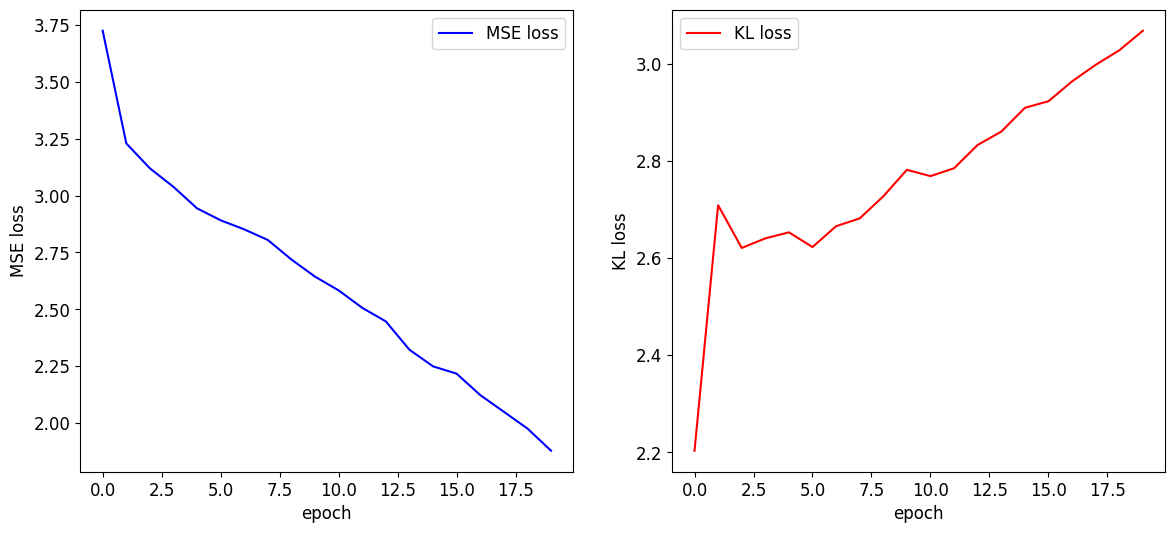

In [19]:
plt.rcParams['font.size'] = 12
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['loss'],label="MSE loss",c="b")
ax.set_xlabel('epoch')
ax.set_ylabel("MSE loss")
ax.legend()
ax=AX[1]
ax.plot(fit.history['kl_loss'],label="KL loss",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [20]:
encoded_test = np.array(vae.encoder.predict(testset))

63/63 [==============================] - 1s 12ms/step


In [21]:
print(encoded_test.shape)

(3, 2000, 100)


z_mean are the first dimension, z_log_var the second (used in training), we're interested in the third dimension, which are the sampled z

In [22]:
dim1 = encoded_test[2,:,:]
print(dim1.shape)

(2000, 100)


Sampling in the latent space is reasonably gaussian as expected

In [23]:
#df = pd.DataFrame(dim1, columns=["x", "y"])
#sns.jointplot(x="x", y="y", data=df);

We can now use the data to decode

In [24]:
decoded_test = np.array(decoder.predict(encoded_test[2,:,:])).reshape(-1,numpart,dim)
print(decoded_test.shape)

63/63 [==============================] - 1s 13ms/step
(2000, 24, 2)


#### Check reconstruction

In [25]:
decoded_test[1]

array([[ 5.3847823 ,  5.235876  ],
       [ 1.5816098 ,  5.6036205 ],
       [ 3.1625583 ,  3.748538  ],
       [ 1.4994336 ,  6.7948546 ],
       [ 2.5353084 ,  3.5843382 ],
       [ 1.8846098 ,  4.041558  ],
       [ 4.8446574 ,  5.6583457 ],
       [ 1.5877304 ,  5.5931478 ],
       [ 4.173245  ,  4.3869085 ],
       [ 3.4825718 ,  3.644374  ],
       [ 1.6977283 ,  2.3272357 ],
       [ 3.7559948 ,  1.3335408 ],
       [ 4.3826976 ,  5.1494493 ],
       [ 5.32195   ,  6.946175  ],
       [ 3.797332  ,  6.130505  ],
       [ 2.978876  ,  7.4384084 ],
       [ 2.5846512 ,  4.2153244 ],
       [ 8.855645  ,  2.9227204 ],
       [ 3.203985  ,  4.3113246 ],
       [ 1.3958317 ,  2.7841806 ],
       [ 6.0934296 ,  3.3929408 ],
       [ 7.005344  ,  3.302608  ],
       [ 6.361611  ,  1.570658  ],
       [ 2.289038  , -0.09432283]], dtype=float32)

In [26]:
ts = testset.reshape(-1,numpart,dim)
print(ts[1,:,:])

[[4.932994 4.616597]
 [1.254589 7.873571]
 [4.823582 3.500449]
 [2.248335 4.285523]
 [0.822091 5.822735]
 [3.311856 2.977378]
 [3.009099 7.627949]
 [0.021698 7.291235]
 [3.701576 5.497831]
 [1.006858 4.678355]
 [1.099941 3.476478]
 [3.139094 1.419121]
 [2.869416 6.237726]
 [5.884103 5.215584]
 [4.739867 5.760788]
 [1.959901 5.614711]
 [3.851805 4.160261]
 [7.3156   2.58269 ]
 [1.896512 6.751844]
 [0.417868 1.859533]
 [5.909309 3.674668]
 [7.528054 1.420197]
 [6.535361 1.764241]
 [3.918503 0.022449]]


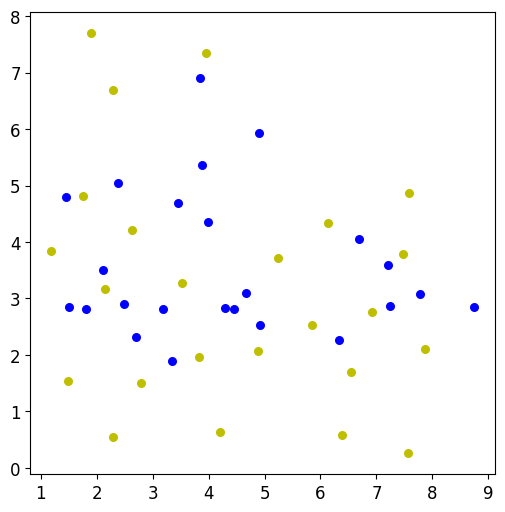

In [27]:
if dim == 2:
    plt.figure(figsize=(6, 6))
    plt.scatter(decoded_test[1,:,0], decoded_test[1,:,1], s=30, c="b")
    plt.scatter(ts[1,:,0], ts[1,:,1], s=30, c="y")

In [28]:
if dim ==3:
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(decoded_test[1,:,0], decoded_test[1,:,1],decoded_test[1,:,2], s=30, c="b", depthshade=True)
    ax.scatter(ts[1,:,0], ts[1,:,1],ts[1,:,2], s=30, c="y", depthshade=True)
    ax.view_init(45,45)